# Transfer Kernel Model Simulation

In [1]:
%run -m ipy_startup
%run -m ipy_logging
%run -m ipy_plotly
%run -m ipy_seaborn
%matplotlib inline
import tensorflow as tf
import edward as ed
from edward.models import Normal, Bernoulli, Categorical
from mgds.data_modeling.nbfn import mkl as mkl
from mgds.data_aggregation import source as src
from mgds.data_modeling.nbfn import drugs as mgds_drugs
# from mgds.data_modeling.nbfn import model_mkl04 as mklmodel
from mgds.data_modeling.nbfn import model_mkl05 as mklmodel
from ml.edward import models as ed_models
from ml.tensorflow.utilities import tf_eval
from sklearn.model_selection import train_test_split
SEED = 1
RES_DIR = '/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations'

2017-04-24 04:43:28,243:DEBUG:requests.packages.urllib3.connectionpool: Starting new HTTPS connection (1): api.plot.ly


# Load True Covariates

In [2]:
from sklearn.preprocessing import StandardScaler

X_rppa_raw, Y_rppa_raw, df_rppa = mkl.get_tcga_modeling_data('brca')
target_drugs = list(np.unique(mgds_drugs.GDSC_PAPER_DRUGS + mgds_drugs.DEFAULT_DRUGS))
X_drug_raw, Y_drug_raw = mkl.get_rx_modeling_data(
    drugs=target_drugs, genes=X_rppa_raw.columns.tolist(), 
    ge_src=src.CCLE_v1, site='BREAST'
)

X_drug_raw = pd.DataFrame(StandardScaler().fit_transform(X_drug_raw.values), index=X_drug_raw.index, columns=X_drug_raw.columns)
X_rppa_raw = pd.DataFrame(StandardScaler().fit_transform(X_rppa_raw.values), index=X_rppa_raw.index, columns=X_rppa_raw.columns)

2017-04-24 04:43:33,479:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/tcga_v1_raw-data-matrices.pkl"
2017-04-24 04:43:58,365:INFO:mgds.data_modeling.nbfn.mkl: Imputing 530 X values of 5406245
2017-04-24 04:44:03,636:INFO:mgds.data_modeling.nbfn.mkl: Imputing 0 Y values of 68107
2017-04-24 04:44:03,647:DEBUG:py_utils.io_utils: Restoring serialized object from location "/Users/eczech/data/research/mgds/prep/mgds_v1_raw-features.pkl"
/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/ipkernel.py:196: PerformanceWarning:

indexing past lexsort depth may impact performance.

2017-04-24 04:44:18,475:INFO:mgds.data_modeling.nbfn.mkl: Removing 37 drugs of 233 due to having more than 30.0% null records


[Remove X records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove Y records with null X values] Records before = 1473, Records after = 967, Records removed = 506 (%34.35)
[Remove X records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)
[Remove Y records with null Y values] Records before = 967, Records after = 639, Records removed = 328 (%33.92)


In [12]:
X_drug = X_drug_raw.reset_index(drop=True).sample(n=300, replace=True)
X_rppa = X_rppa_raw.reset_index(drop=True).sample(n=600, replace=True)

X_drug, X_rppa = X_drug.iloc[:, :150], X_rppa.iloc[:, :150]

In [13]:
assert np.all(X_drug.notnull())
assert np.all(X_rppa.notnull())

In [14]:
X_rppa, X_rppa_test = train_test_split(X_rppa, test_size=.15)

In [15]:
X_drug.shape, X_rppa.shape, X_rppa_test.shape

((300, 150), (510, 150), (90, 150))

In [16]:
Y_drug_raw.shape, Y_rppa_raw.shape

((46, 196), (403, 169))

# Configuration

In [934]:
# Actual Config
P = X_drug.shape[1]

Nr = X_rppa.shape[0]
Nd = X_drug.shape[0]
Nr_test = X_rppa_test.shape[0]



# Config w/ good selection
# Tr = 30
# Td = 15
# p_rppa = 25
# p_drug = 3
# sim_type = 'actual'


# Tr = Y_rppa_raw.shape[1]
# Td = Y_drug_raw.shape[1]
Tr = 100
Td = 25

p_rppa = 10
p_drug = 3
sim_type = 'actual'

w_rppa_sigma = .25
w_drug_sigma = 5.
#y_sigma = .1
y_sigma = .25

def plot_file(filename):
    return os.path.join(RES_DIR, sim_type, filename)

# Simulation

In [243]:
# from sklearn.metrics.pairwise import rbf_kernel
# from edward.models import Normal, Bernoulli, Categorical

# def run(T):
#     return tf_eval(T)

# def get_rppa_weights():
# #     p = p_rppa
# #     assert Nr >= p
# #     p = float(p)/Nr
    
#     selector = tf.cast(tf.transpose(tf.one_hot(Categorical(p=np.ones(Nr) / Nr).sample(Tr), depth=Nr)), dtype=tf.float32)
#     #weight = Normal(mu=tf.zeros([Nr, Tr]), sigma=w_rppa_sigma * tf.ones([Nr, Tr]))
#     weight = 2. * tf.cast(Bernoulli(p=.5*np.ones([Nr, Tr])), dtype=tf.float32) - 1.
#     return run(weight * selector) # Nr x Tr

# def get_drug_weights():
#     p = p_drug
#     assert Tr >= p
#     p = float(p)/Tr
#     weight = Normal(mu=tf.zeros([Tr, Td]), sigma=w_drug_sigma * tf.ones([Tr, Td]))
#     weight = w_drug_sigma * tf.nn.tanh(100.* weight)
#     W = run(weight)
#     W[p_drug:,:] = 0.
#     return W


# def get_drug_response(Xd, Xr, Wd, Wr, gamma):
#     # Xd = Nd x P
#     # Wd = Tr x Td
#     # Wr = P x Tr
#     K = rbf_kernel(Xd, Y=Xr, gamma=gamma)
#     # print('drug: ', pd.Series(K.ravel()).describe())
#     Yr = np.matmul(K, Wr) # Nd x Tr
#     Yd = np.matmul(Yr, Wd) # Nd x Td
#     Y = Normal(mu=tf.constant(Yd), sigma=y_sigma * tf.ones_like(Yd))
#     return run(Y) # Nd x Td

# def get_rppa_response(Xr1, Xr2, Wr, gamma):
#     # Xr = Nr x P
#     # Wr = P x Tr
#     K = rbf_kernel(Xr1, Xr2, gamma=gamma)
#     # print(pd.Series(K.ravel()).describe())
#     Yr = np.matmul(K, Wr) # Nr x Tr
#     Y = Normal(mu=tf.constant(Yr), sigma=y_sigma * tf.ones_like(Yr))
#     return run(Y) # Nr x Tr
    

# def get_simulation_data():
#     Xd = X_drug.values
#     Xr = X_rppa.values
#     Xr_test = X_rppa_test.values
    
#     Wd = get_drug_weights()
#     Wr = get_rppa_weights()
    
#     gamma = 1. / Xr.shape[0]
#     Yd = get_drug_response(Xd, Xr, Wd, Wr, gamma)
#     Yr = get_rppa_response(Xr, Xr, Wr, gamma)
#     Yr_test = get_rppa_response(Xr_test, Xr, Wr, gamma)
    
#     #Y = None
#     return (
#         pd.DataFrame(Xd).add_prefix('DX'), pd.DataFrame(Xr).add_prefix('RX'), pd.DataFrame(Xr_test).add_prefix('RXT'), 
#         pd.DataFrame(Yd).add_prefix('DY'), pd.DataFrame(Yr).add_prefix('RY'), pd.DataFrame(Yr_test).add_prefix('RYT'),
#         Wd, Wr
#     )

# tf.reset_default_graph()
# np.random.seed(SEED)
# tf.set_random_seed(SEED)
# with tf.device('/cpu:0'):
#     sim_data = get_simulation_data()
#     Xd, Xr, Xr_test, Yd, Yr, Yr_test, Wd, Wr = sim_data

In [935]:
def run(T):
    return tf_eval(T)

# def get_rppa_covariates():
#     X = Normal(mu=1.*np.zeros([Nr, P]), sigma=1.*np.ones([Nr, P]))
#     return run(X)

# def get_drug_covariates():
#     X = Normal(mu=1.*np.zeros([Nd, P]), sigma=1.*np.ones([Nd, P]))
#     return run(X)

# def get_rppa_weights():
#     p = p_rppa
#     assert P >= p
#     p = float(p)/P
#     selector = tf.cast(Bernoulli(p=p*np.ones([P, Tr])), dtype=tf.float32)
#     weight = Normal(mu=tf.zeros([P, Tr]), sigma=w_rppa_sigma * tf.ones([P, Tr]))
#     return run(weight * selector) # P x Tr

def get_rppa_weights():
    assert Tr >= p_rppa
    weight = Normal(mu=tf.zeros([P, Tr]), sigma=w_rppa_sigma * tf.ones([P, Tr]))
    W = run(weight)
    W[:,p_rppa:] = 0.
    return W

def get_drug_weights():
    assert p_rppa >= p_drug
    weight = Normal(mu=tf.zeros([Tr, Td]), sigma=w_drug_sigma * tf.ones([Tr, Td]))
    weight = w_drug_sigma * tf.nn.tanh(100.* weight)
    W = run(weight)
    W[p_drug:,:] = 0.
    return W


def get_drug_response(Xd, Wd, Wr):
    # Xd = Nd x P
    # Wd = Tr x Td
    # Wr = P x Tr
    Yr = np.matmul(Xd, Wr) # Nd x Tr
    Yd = np.matmul(Yr, Wd) # Nd x Td
    Y = Normal(mu=tf.constant(Yd), sigma=y_sigma * tf.ones_like(Yd))
    return run(Y) # Nd x Td

def get_rppa_response(Xr, Wr):
    # Xr = Nr x P
    # Wr = P x Tr
    Yr = np.matmul(Xr, Wr) # Nr x Tr
    Y = Normal(mu=tf.constant(Yr), sigma=y_sigma * tf.ones_like(Yr))
    return run(Y) # Nr x Tr
    

def get_simulation_data():
    Xd = X_drug.values
    Xr = X_rppa.values
    Xr_test = X_rppa_test.values
    
    Wd = get_drug_weights()
    Wr = get_rppa_weights()
    
    Yd = get_drug_response(Xd, Wd, Wr)
    Yr = get_rppa_response(Xr, Wr)
    Yr_test = get_rppa_response(Xr_test, Wr)
    
    #Y = None
        
    return (
        pd.DataFrame(Xd).add_prefix('DX'), pd.DataFrame(Xr).add_prefix('RX'), pd.DataFrame(Xr_test).add_prefix('RXT'), 
        pd.DataFrame(Yd).add_prefix('DY'), pd.DataFrame(Yr).add_prefix('RY'), pd.DataFrame(Yr_test).add_prefix('RYT'),
        Wd, Wr
    )

tf.reset_default_graph()
np.random.seed(SEED)
tf.set_random_seed(SEED)
with tf.device('/cpu:0'):
    sim_data = get_simulation_data()
    Xd, Xr, Xr_test, Yd, Yr, Yr_test, Wd, Wr = sim_data

In [677]:
for a in sim_data:
    print(a.shape)

(300, 150)
(510, 150)
(90, 150)
(300, 25)
(510, 169)
(90, 169)
(169, 25)
(150, 169)


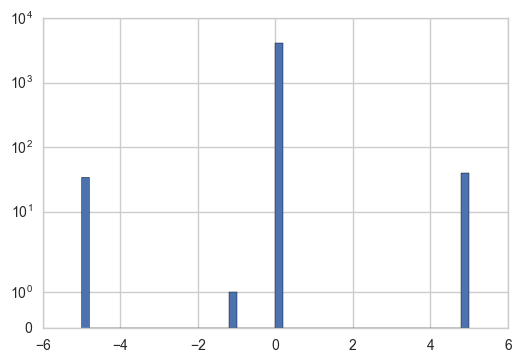

In [755]:
ax = pd.DataFrame(Wd).stack().hist(bins=50)
ax.set_yscale('symlog')

In [368]:
Xd.stack().describe()

count    45000.000000
mean        -0.002438
std          1.004457
min         -4.686763
25%         -0.644458
50%         -0.138177
75%          0.549463
max          6.622827
dtype: float64

In [369]:
Xr.stack().describe()

count    76500.000000
mean        -0.003498
std          0.992270
min         -6.950083
25%         -0.657394
50%         -0.053679
75%          0.603216
max         11.175452
dtype: float64

In [370]:
Yd.stack().describe()

count    4500.000000
mean        0.018601
std         3.056744
min        -9.401889
25%        -1.803767
50%         0.023243
75%         1.881334
max        10.328088
dtype: float64

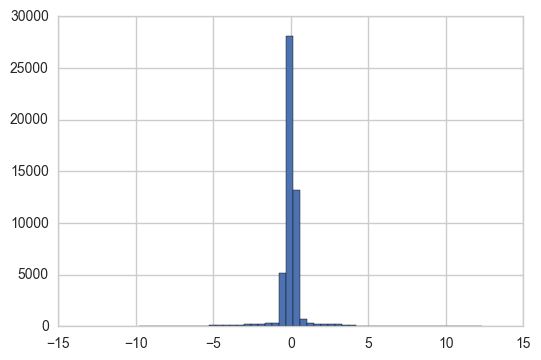

In [936]:
Yr.stack().hist(bins=50)

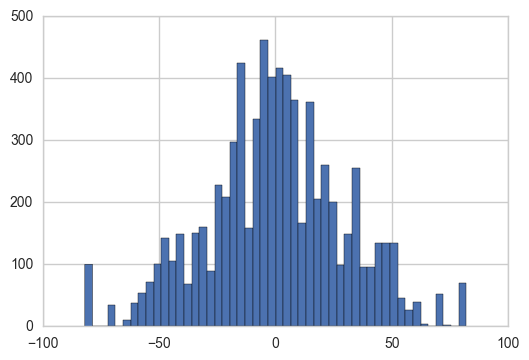

In [937]:
Yd.stack().hist(bins=50)

In [175]:
Yd.describe()

DY0         DY1         DY2         DY3         DY4         DY5  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean    -2.428327    2.292242   -2.279827    0.015065    2.227960    2.484237   
std      0.579357    0.571281    0.531905    0.519078    0.556869    0.594818   
min     -4.316904    0.019879   -3.691583   -1.524909    0.414613    0.876416   
25%     -2.790539    1.957361   -2.644018   -0.316747    1.884945    2.111262   
50%     -2.449920    2.294288   -2.276145    0.025872    2.210228    2.467969   
75%     -2.019036    2.686494   -1.942176    0.368046    2.597889    2.852769   
max     -0.514167    4.015526   -0.580470    1.659034    3.833305    3.904446   

              DY6         DY7         DY8         DY9        DY10        DY11  \
count  300.000000  300.000000  300.000000  300.000000  300.000000  300.000000   
mean     2.390474    2.473948   -2.238232    2.227884    2.253351   -2.256686   
std      0.562174    0.551126    0.536044    0.538876    0.499353    0.552400   
min      0.822449    0.564567   -3.785262    0.004100    0.754390   -3.613534   
25%      2.010370    2.104541   -2.597412    1.893965    1.950723   -2.671627   
50%      2.388605    2.457068   -2.209276    2.287995    2.235408   -2.258565   
75%      2.774146    2.829363   -1.902789    2.565142    2.603773   -1.936639   
max      3.813594    4.073305   -0.724836    4.011462    3.550863   -0.184576   

             DY12        DY13        DY14  
count  300.000000  300.000000  300.000000  
mean    -2.216505    2.463927   -2.448786  
std      0.524492    0.594446    0.541910  
min     -3.681710    0.586481   -3.919508  
25%     -2.608606    2.063884   -2.841087  
50%     -2.211005    2.481852   -2.478250  
75%     -1.837705    2.860138   -2.104553  
max     -0.407156    3.948331   -0.530705

In [176]:
Yr.stack().describe()

count    15300.000000
mean         0.236543
std          0.915550
min         -3.194553
25%         -0.360442
50%          0.237356
75%          0.812096
max          4.354573
dtype: float64

In [177]:
Yr_test.stack().describe()

count    2700.000000
mean        0.246466
std         0.892523
min        -2.860418
25%        -0.353090
50%         0.249723
75%         0.817485
max         4.023033
dtype: float64

## Simulation Validation

### RPPA Weights

In [490]:
# RPPA weights should have at least some non-zero entries in columns or there will be no 
# connection to RPPA outputs.  In addition, the mean number of non-zero entries should be p_rppa
Wr.shape 

(150, 30)

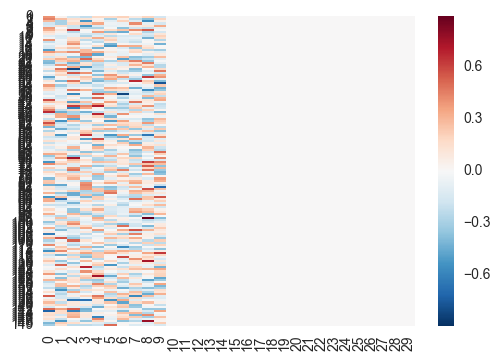

In [556]:
#plt.figure(figsize=(8,24))
sns.heatmap(Wr)

In [492]:
#pd.Series((np.abs(Wr) > 0).sum(axis=0)).mean(), p_rppa
pd.Series((np.abs(Wr) > 0).sum(axis=0)).value_counts()

0      20
150    10
dtype: int64

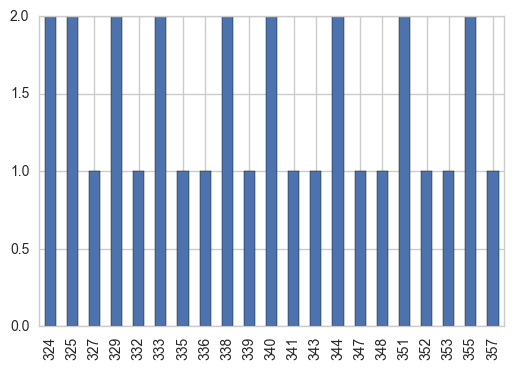

In [166]:
pd.Series((np.abs(Wr) > 0).sum(axis=0)).value_counts().sort_index().plot(kind='bar')

### Drug Weights

In [493]:
# RPPA->Drug weights should have at least some non-zero entries in columns or there will be no 
# connection between Genetic data and drug sensitivity outputs.  
# In addition, the mean number of non-zero entries should be p_drug
Wd.shape

(30, 100)

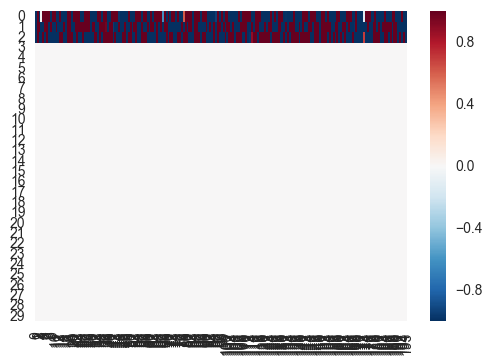

In [557]:
sns.heatmap(Wd)

In [74]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).mean(), p_drug

(9.0204081632653068, 8)

In [75]:
pd.Series((np.abs(Wd) > 0).sum(axis=0)).value_counts()

9     27
10    24
8     24
7     24
11    23
6     17
12    14
5     13
13    10
14     5
3      4
16     3
15     3
4      3
18     1
2      1
dtype: int64

# Cross Validation

In [23]:
# from ml.tensorflow import utilities as tf_utils
# tf.reset_default_graph()
# v = tf.contrib.distributions.StudentT(df=3., mu=0., sigma=.1).sample(100000)
# ax = pd.Series(tf_utils.tf_eval(v)).hist(bins=50)
# ax.set_yscale('symlog')

In [939]:
import imp
imp.reload(mklmodel)
imp.reload(ed_models)

<module 'ml.edward.models' from '/Users/eczech/repos/portfolio/functional/ml/python/ml/edward/models.py'>

In [940]:
def get_mkl_model(fold_id):
    tf.reset_default_graph()
    model = mklmodel.MTKLModel(
        Xr.values, Yr.values, gamma=None, print_kernel_stats=False,
        h_scale=1., w_scale=1.,
        rppa_scale=.1, rx_scale=.1, rppa_rx_scale=.3
    )
    est = ed_models.BayesianModelEstimator(
        model, n_collect=1, n_print_progress=500, random_state=SEED, 
        fail_if_not_converged=False, max_steps=5000,
        inference_fn=ed.MAP
    )
    est.set_log_dir('/tmp/mkl4simactual/{}'.format(fold_id))
    return est

In [912]:
# ! rm -rf /tmp/mkl4sim/*
# get_mkl_model(0).fit(Xd.values, Yd.values)

In [913]:
# import imp
# imp.reload(trainer)

In [941]:
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyRegressor
from ml.edward import models as ed_models
from ml.api import trainer
from sklearn.model_selection import KFold
    
ests = {
#     'lasso': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         #('pca', PCA(n_components=.9999)),
#         ('est', MultiOutputRegressor(LassoCV(random_state=SEED, n_alphas=25)))
#     ]),
    'ridge': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('est', MultiOutputRegressor(RidgeCV(alphas=np.logspace(-3, 6, 25))))
    ]),
#     'svr': lambda i: Pipeline([
#         ('scale', StandardScaler()),
#         ('est', MultiOutputRegressor(GridSearchCV(SVR(), {'C': np.logspace(-2, 5, 10)})))
#     ]),
    'pcareg': lambda i: Pipeline([
        ('scale', StandardScaler()),
        ('pca', PCA(n_components=10)),
        ('est', MultiOutputRegressor(LinearRegression()))
    ]),
    'tkm': get_mkl_model,
    'baseline': lambda i: MultiOutputRegressor(DummyRegressor(strategy='mean'))
}

K = 5
cv = KFold(n_splits=K, random_state=SEED, shuffle=True).split(Xd)

def fit_fn(est_name, est, X_train, Y_train, X_test, Y_test, fold):
    if est_name == 'tkm':
        est = est.fit(X_train.values, Y_train.values)
        est.all_tensors_ = est.get_all_tensors()
        return est
    else:
        return est.fit(X_train, Y_train)

config = trainer.TrainerConfig(refit=True, model_fit_fn=fit_fn)
cv_trainer = trainer.Trainer(config)

In [942]:
! rm -rf /tmp/mkl4simactual/*
train_res = cv_trainer.train_regressors(Xd, Yd, ests, cv)

2017-04-24 09:23:38,216:INFO:ml.model.log: Running model baseline (DummyRegressor) on fold 1 ==> dim(X_train) = (240, 150), dim(X_test) = (60, 150), dim(Y_train) = (240, 25), dim(Y_test) = (60, 25)
2017-04-24 09:23:38,230:INFO:ml.model.log: Running model pcareg (Pipeline) on fold 1 ==> dim(X_train) = (240, 150), dim(X_test) = (60, 150), dim(Y_train) = (240, 25), dim(Y_test) = (60, 25)
2017-04-24 09:23:38,259:INFO:ml.model.log: Running model ridge (Pipeline) on fold 1 ==> dim(X_train) = (240, 150), dim(X_test) = (60, 150), dim(Y_train) = (240, 25), dim(Y_test) = (60, 25)


Beginning cross validation (see /tmp/ml-models-exec.log for progress updates)


2017-04-24 09:23:38,549:INFO:ml.model.log: Running model tkm (BayesianModelEstimator) on fold 1 ==> dim(X_train) = (240, 150), dim(X_test) = (60, 150), dim(Y_train) = (240, 25), dim(Y_test) = (60, 25)
2017-04-24 09:23:40,110:INFO:root: On iteration 0 of at most 5000 (loss = 2823613.5, loss change = None)
2017-04-24 09:23:42,017:INFO:root: On iteration 500 of at most 5000 (loss = 1949285.75, loss change = -507.0625)
2017-04-24 09:23:43,792:INFO:root: On iteration 1000 of at most 5000 (loss = 1712599.0, loss change = -943.7750244140625)
2017-04-24 09:23:45,567:INFO:root: On iteration 1500 of at most 5000 (loss = 1596105.5, loss change = -387.20001220703125)
2017-04-24 09:23:47,339:INFO:root: On iteration 2000 of at most 5000 (loss = 1521418.125, loss change = 50.95000076293945)
2017-04-24 09:23:49,117:INFO:root: On iteration 2500 of at most 5000 (loss = 1479605.875, loss change = -145.1750030517578)
2017-04-24 09:23:50,895:INFO:root: On iteration 3000 of at most 5000 (loss = 1452905.875,

Beginning model refitting


2017-04-24 09:25:20,572:INFO:ml.model.log: Running model tkm (BayesianModelEstimator) on fold 0 ==> dim(X_train) = (300, 150), dim(X_test) = (300, 150), dim(Y_train) = (300, 25), dim(Y_test) = (300, 25)
2017-04-24 09:25:22,127:INFO:root: On iteration 0 of at most 5000 (loss = 2896392.0, loss change = None)
2017-04-24 09:25:24,007:INFO:root: On iteration 500 of at most 5000 (loss = 2071840.75, loss change = 133.8125)
2017-04-24 09:25:25,848:INFO:root: On iteration 1000 of at most 5000 (loss = 1846316.0, loss change = -259.8125)
2017-04-24 09:25:27,695:INFO:root: On iteration 1500 of at most 5000 (loss = 1713769.375, loss change = 903.5499877929688)
2017-04-24 09:25:29,547:INFO:root: On iteration 2000 of at most 5000 (loss = 1653770.875, loss change = -168.21249389648438)
2017-04-24 09:25:31,389:INFO:root: On iteration 2500 of at most 5000 (loss = 1602385.625, loss change = -91.86250305175781)
2017-04-24 09:25:33,233:INFO:root: On iteration 3000 of at most 5000 (loss = 1574221.0, loss ch

In [943]:
from ml.api.results import predictions
d_pred = predictions.extract(train_res)
d_pred_melt = predictions.melt(train_res, d_pred)
d_pred_melt.head()

Actual  Fold     Model  Predicted Task
0    5.153522     1  baseline   -1.73874  DY0
4   13.237249     1  baseline   -1.73874  DY0
11   0.121744     1  baseline   -1.73874  DY0
12  49.119481     1  baseline   -1.73874  DY0
16   6.324346     1  baseline   -1.73874  DY0

In [944]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']

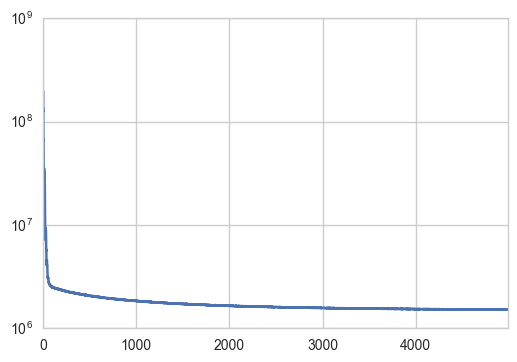

In [945]:
ax = pd.Series(est.clf.losses_[10:]).plot()
ax.set_yscale('symlog')

In [946]:
H = est.clf.get_tensor('qH')
H.shape

(510, 100)

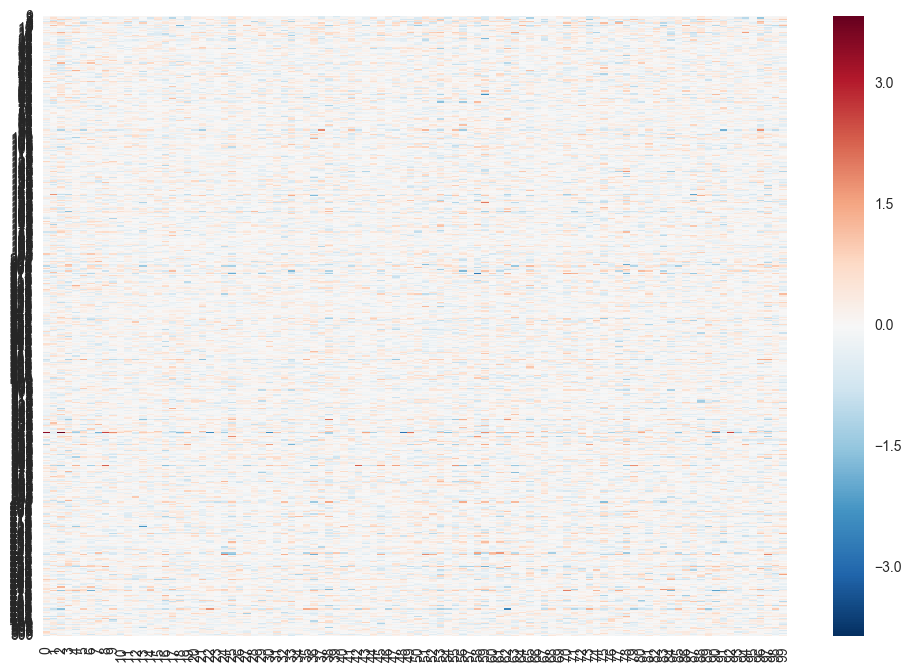

In [947]:
plt.figure(figsize=(12,8))
sns.heatmap(H)

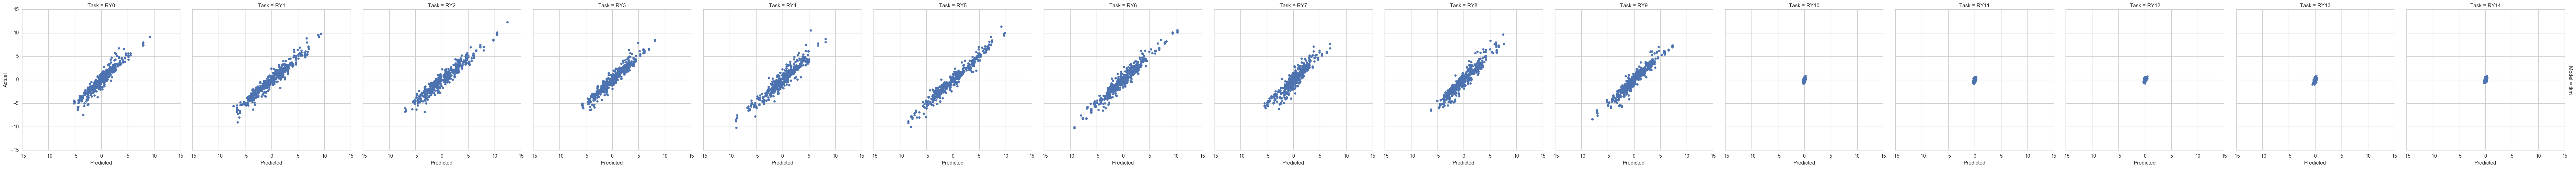

In [948]:
# Predictions on RPPA training data
Yp = pd.DataFrame(est.clf.model.y_rppa_scaler.inverse_transform(est.clf.get_tensor('qYR')), index=Yr.index, columns=Yr.columns)
d_pred_train = mkl.stack_predictions(Yp, Yr).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
#tasks = d_pred_train['Task'].sample(n=25, replace=False, random_state=SEED)
tasks = d_pred_train['Task'].unique()[:15]
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
#g.savefig(plot_file('pred_train_rppa.png'))

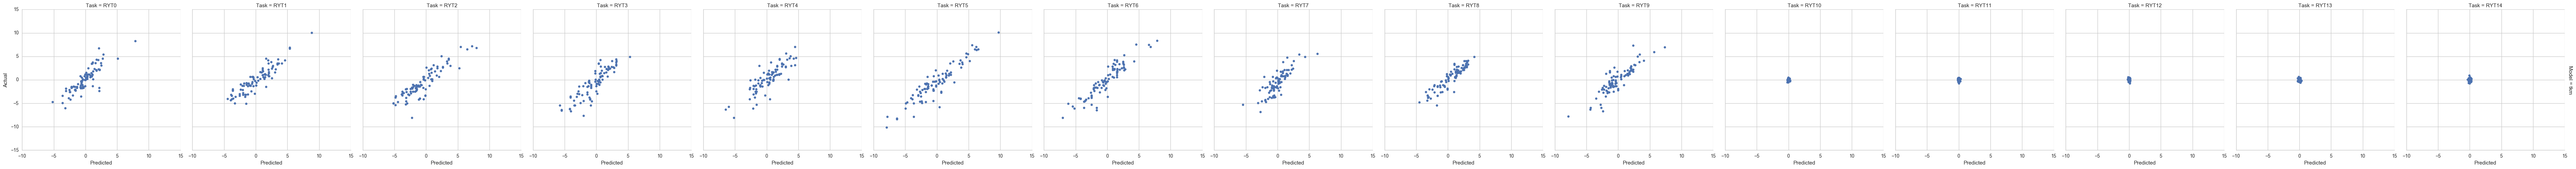

In [949]:
# Predictions on RPPA test data
Yp = pd.DataFrame(est.clf.criticism_args_['pred_rppa_fn'](Xr_test), index=Yr_test.index, columns=Yr_test.columns)
d_pred_rppa = mkl.stack_predictions(Yp, Yr_test).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
#tasks = d_pred_rppa['Task'].sample(n=15, replace=False, random_state=SEED)
tasks = d_pred_rppa['Task'].unique()[:15]
g = predictions.visualize(train_res, d_pred_rppa[d_pred_rppa['Task'].isin(tasks)], share_axes=True)
# g.savefig(plot_file('pred_train_rppa.png'))

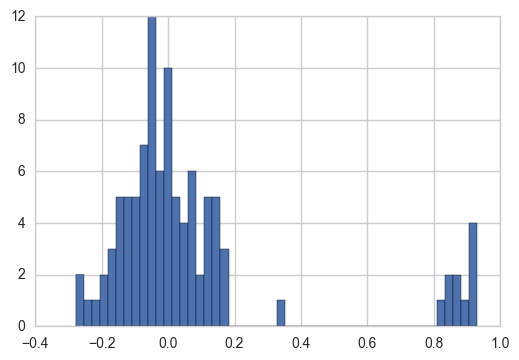

In [950]:
d_pred_rppa.groupby('Task').apply(lambda g: g['Predicted'].corr(g['Actual'])).hist(bins=50)

In [951]:
d_pred_rppa.groupby('Task').apply(lambda g: g['Predicted'].corr(g['Actual'])).describe()

count    100.000000
mean       0.071257
std        0.293522
min       -0.277445
25%       -0.077190
50%       -0.009155
75%        0.092315
max        0.931567
dtype: float64

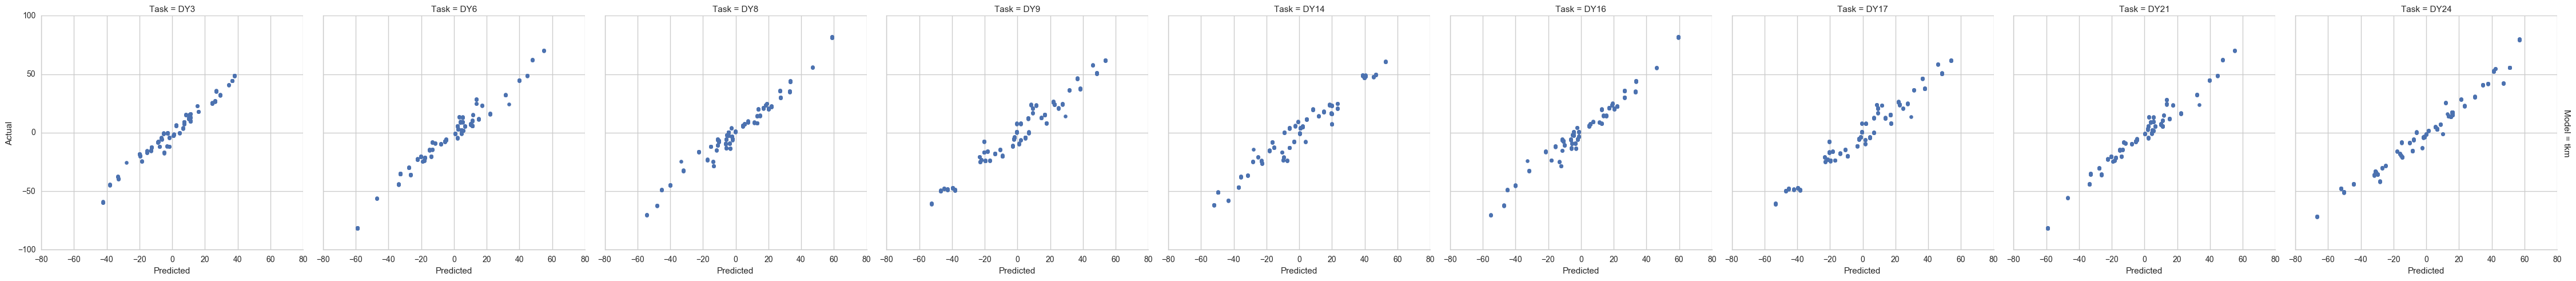

In [952]:
# Predictions on drug training data
Yp = est.clf.predict(Xd.values)
d_pred_train = mkl.stack_predictions(Yp, Yd).reset_index().assign(Model='tkm', Fold=0).rename(columns={'Pred': 'Predicted'})
tasks = d_pred_train['Task'].sample(n=10, replace=False, random_state=SEED)
g = predictions.visualize(train_res, d_pred_train[d_pred_train['Task'].isin(tasks)], share_axes=True)
#g.savefig(plot_file('pred_train_drug.png'))

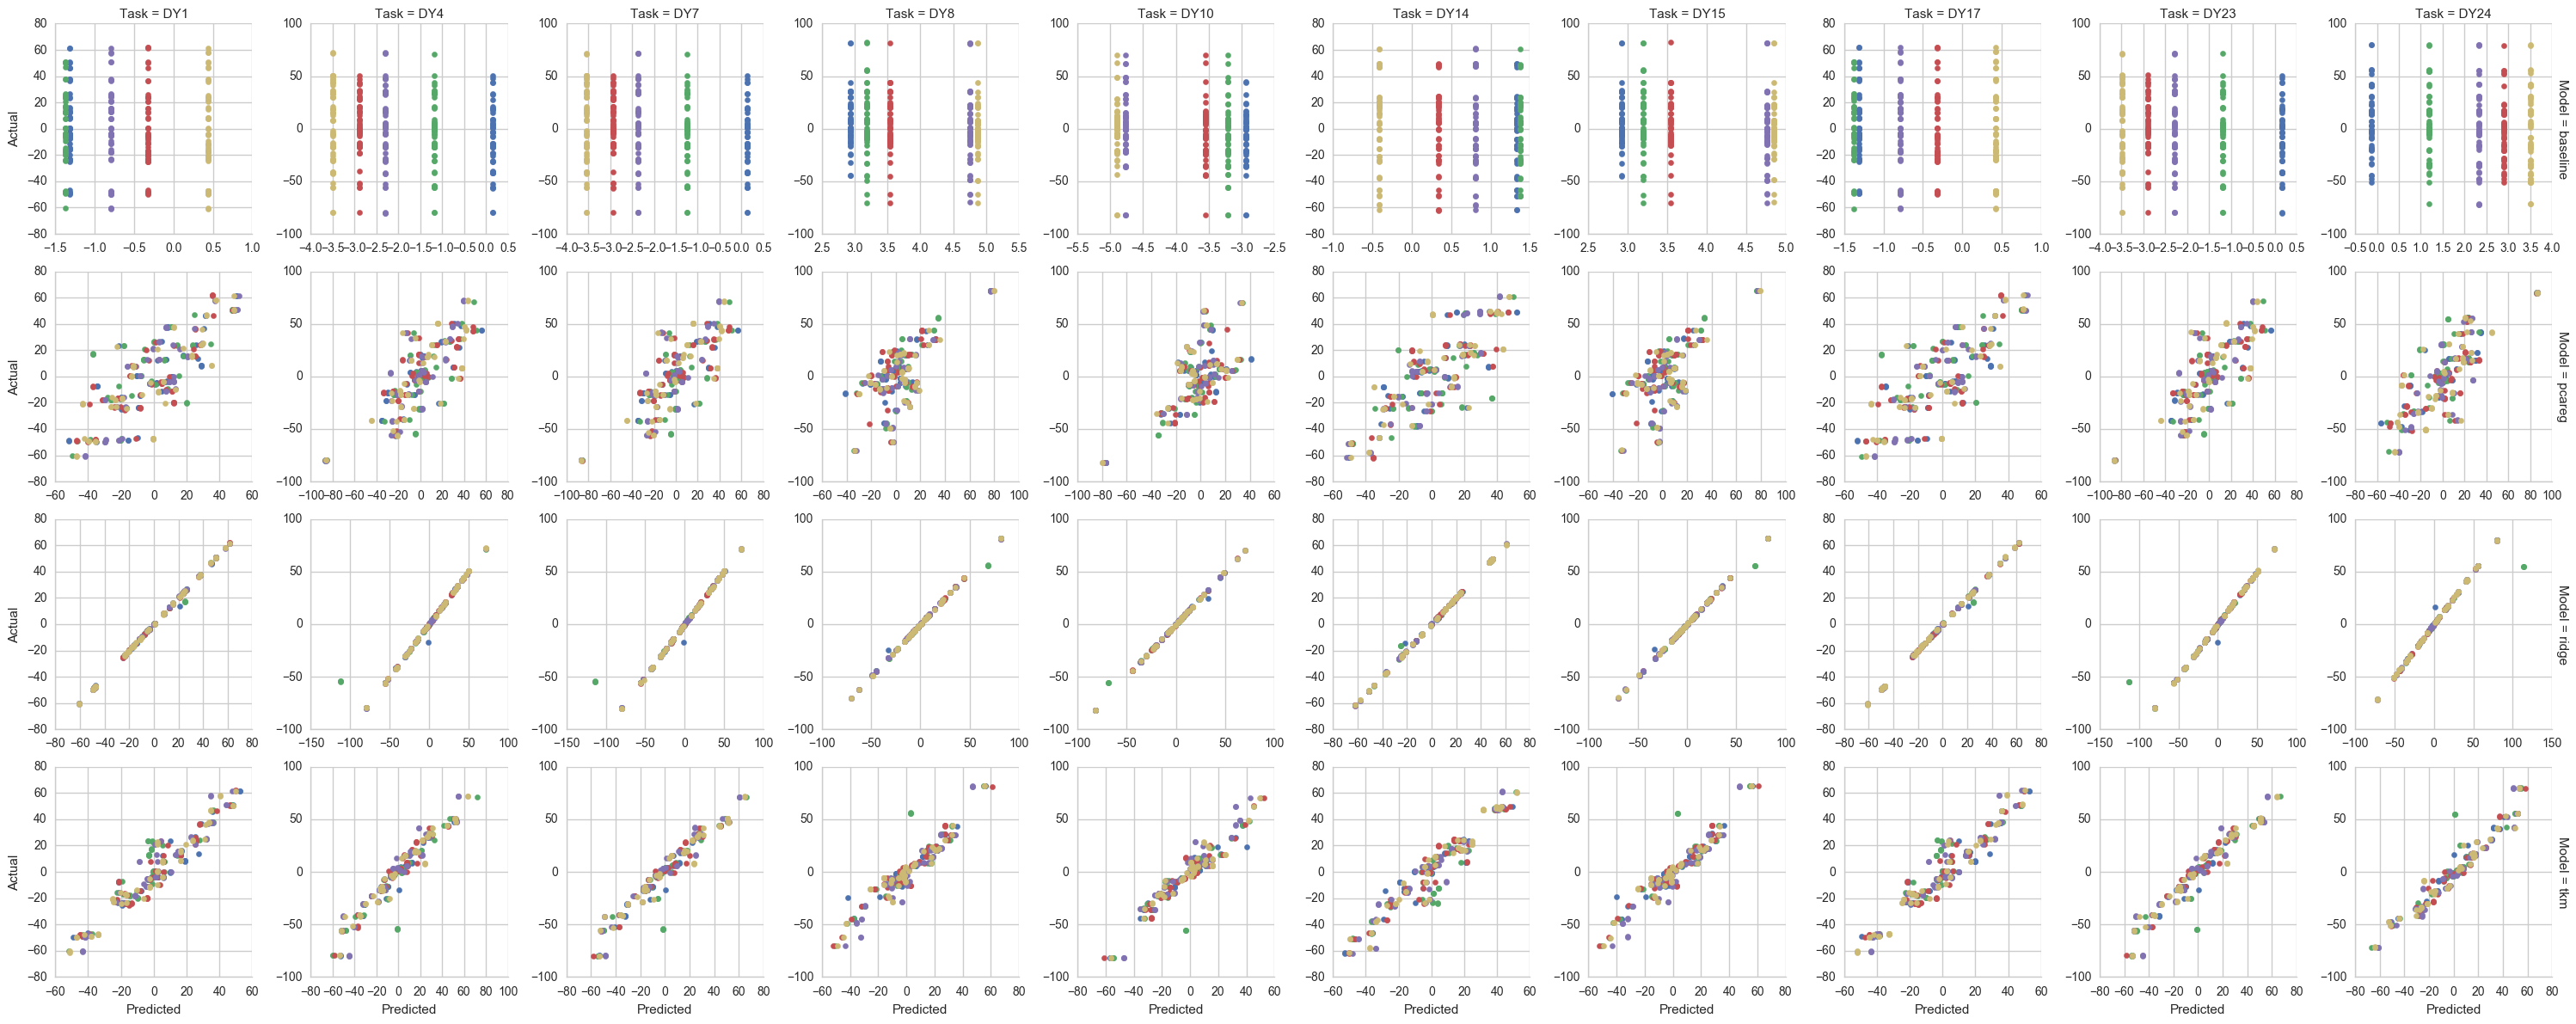

In [953]:
tasks = d_pred_melt['Task'].sample(n=10, random_state=SEED)
g = predictions.visualize(train_res, d_pred_melt[d_pred_melt['Task'].isin(tasks)], share_axes=False, figsize=3)
#g.savefig(plot_file('pred_sample.png'))

In [954]:
from ml.api.results import performance
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr

def score_fn(y_true, y_pred):
    return {
        'pearson': y_true.corr(y_pred, method='pearson'),
        'spearman': y_true.corr(y_pred, method='spearman'),
        'r2_score': r2_score(y_true, y_pred),
        'pearsonp': pearsonr(y_true, y_pred)[1]
    }
d_score = performance.extract(train_res, d_pred, score_fn, by_fold=False)
d_score = performance.melt(d_score)
d_score.head()

Model Fold Task    Metric     Value
0  baseline  All  DY0   pearson -0.106603
1  baseline  All  DY0  pearsonp  0.065187
2  baseline  All  DY0  r2_score -0.006392
3  baseline  All  DY0  spearman -0.112977
4  baseline  All  DY1   pearson -0.090204

In [955]:
def plot_scores(d, metric=None):
    traces = []
    for k, g in d.groupby('Metric'):
        if metric is not None and k != metric:
            continue
        trace = go.Box(x=g['Model'], y=g['Value'], boxmean='sd', boxpoints='all', name=k)
        traces.append(trace)
    layout = go.Layout(boxmode='group', hovermode='closest', title='CV Performance ({} Folds)<br>Metric = {}'.format(K, metric))
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    label = 'all' if metric is None else metric
    filename = plot_file('perf_scores_{}.html'.format(label))
    plty.offline.plt(fig, filename=filename)
    return filename

In [956]:
plot_scores(d_score)

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/perf_scores_all.html'

In [745]:
plot_scores(d_score, metric='pearson')

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/perf_scores_pearson.html'

In [ ]:
plot_scores(d_score, metric='pearsonp')

# Effects

In [957]:
# Get top performing tasks and ONLY look at weights for those
d_top_score = d_score[(d_score['Model'] == 'tkm') & (d_score['Metric'] == 'pearsonp')].sort_values('Value')
d_top_score = d_top_score[d_top_score['Value'] <= .01]
top_tasks = list(d_top_score['Task'].apply(lambda v: int(v.replace('DY', ''))))
len(top_tasks)

25

### TKL Model

In [958]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['tkm']
qW = est.clf.get_tensor('qW')

In [959]:
qW.shape

(100, 25)

In [326]:
# plt.figure(figsize=(12, 5))
# sns.heatmap(np.where(np.abs(qW) < .15, np.nan, qW)[:25, :25])

In [327]:
# plt.figure(figsize=(12, 5))
# #sns.heatmap(np.where(Wd == 0, np.nan, Wd)[:25, :25])
# sns.heatmap(np.where(np.abs(Wd) < .1, np.nan, Wd)[:25, :25])

In [874]:
def plot_weights(W_true, W_pred):
    x = np.concatenate([np.arange(W_true.shape[1]) for i in range(W_true.shape[0])])
    y = np.concatenate([np.repeat(i, W_true.shape[1]) for i in range(W_true.shape[0])])
    z = W_true.ravel()
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['RPPA {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    for i in range(W_true.shape[0]):
        weights = W_true[i,:]
        trace = go.Scatter(
            x=drugs,
            y=np.repeat(proteins[i], len(weights)),
            mode='markers',
            marker=dict(
                size=np.where(np.abs(weights) > 0, 10, 0),
                color=np.where(weights > 0, 'rgb(31, 119, 180)', 'rgb(214, 39, 40)')
            ),
            text=pd.Series(W_true[i,:]).apply(lambda v: 'Actual Weight: {}'.format(v) if not pd.isnull(v) else np.nan),
            hoverinfo='x+y+text',
            showlegend=False
        )
        traces.append(trace)
    layout = go.Layout(
        height=800, 
        hovermode='closest',
        title='Actual vs Estimated Weight Values<br>(dots=Actual, bars=Estimated)'
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_tkm.html')
    plty.offline.plt(fig, filename=filename)
    return filename

In [960]:
Wd.shape, qW.shape

((100, 25), (100, 25))

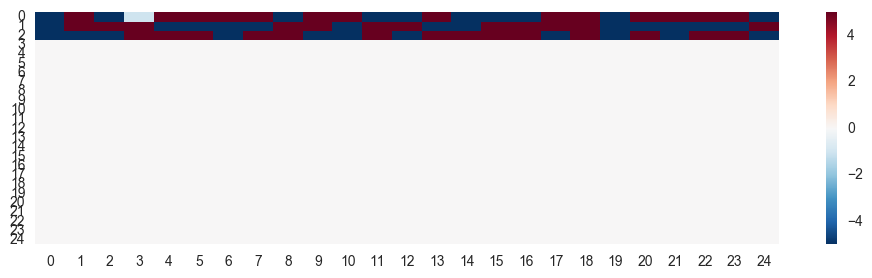

In [961]:
plt.figure(figsize=(12,3))
sns.heatmap(Wd[:25,:])

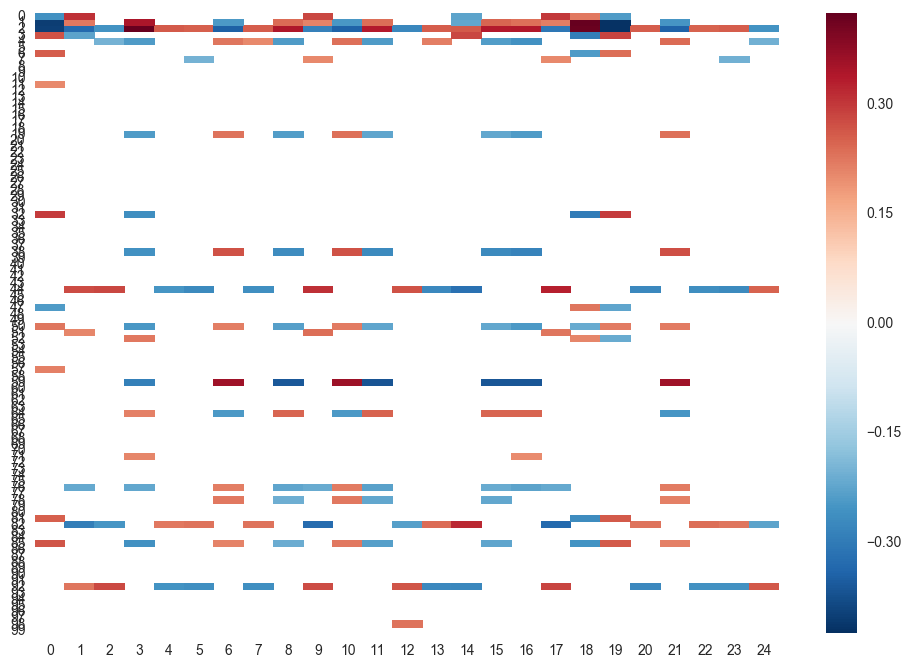

In [963]:
plt.figure(figsize=(12,8))
dt = np.where(np.abs(qW) >= .2, qW, np.nan)
#plt.figure(figsize=(32,4))
sns.heatmap(dt[:,:])

In [964]:
qYD = est.clf.get_tensor('qYD')
qYD.shape

(300, 25)

In [966]:
Tr, Td

(100, 25)

In [95]:
weight_thresh = .1
plot_weights(
    np.where(np.abs(Wd) < .5, np.nan, Wd)[:,top_tasks],
    np.where(np.abs(qW) < weight_thresh, np.nan, qW)[:,top_tasks]
)

/Users/eczech/anaconda/envs/mgds/lib/python3.5/site-packages/ipykernel/__main__.py:28: RuntimeWarning:

invalid value encountered in greater



'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/actual/weight_estimate_tkm.html'

In [583]:
weight_thresh = .5
qWsparse = np.where(np.abs(qW) < weight_thresh, np.nan, qW).ravel()
Wdsparse = np.where(np.abs(Wd) < .5, np.nan, Wd).ravel()
qWselect = (np.abs(np.nan_to_num(qWsparse)) > 0).astype(np.int64)
Wdselect = (np.abs(np.nan_to_num(Wdsparse)) > 0).astype(np.int64)
rctable = pd.DataFrame({'inferred': Wdselect, 'actual': qWselect}).groupby(['inferred', 'actual']).size().unstack()
rctable

actual       0    1
inferred           
0         4765  529
1          108  478

In [826]:
from scipy.stats import fisher_exact, chi2_contingency

fisher_exact(rctable.values), chi2_contingency(rctable.values)

((1.6784654827581578, 2.5103162921673365e-05),
 (20.02764441752749,
  7.6330662828985132e-06,
  1,
  array([[ 30501.95540997,   1229.04459003],
         [  1339.04459003,     53.95540997]])))

## Lasso

In [33]:
from ml.api.results import properties
est = properties.extract_refit_model_map(train_res)['lasso']
qW = []
for e in est.clf.named_steps['est'].estimators_:
    qW.append(e.coef_)
qW = pd.DataFrame(qW).T
qW.shape

(600, 25)

In [34]:
def plot_weight_estimates(W_pred, model='Lasso'):
    
    drugs = ['Drug {}'.format(i) for i in range(W_pred.shape[1])]
    proteins = ['Gene {}'.format(i) for i in range(W_pred.shape[0])]
    
    traces = []
    traces.append(go.Heatmap(
        x=drugs, 
        y=proteins,
        z=W_pred, 
        colorscale='Portland', 
        reversescale=True,
        opacity=.5,
        colorbar=go.ColorBar(title='Weight Value'),
        text=pd.DataFrame(W_pred).applymap(lambda v: 'Estimated Weight: {}'.format(v)).values,
        hoverinfo='x+y+text'
    ))
    layout = go.Layout(
        height=2000, 
        hovermode='closest',
        title='Estimated Weight Values<br>({} Model)'.format(model)
    )
    fig = go.Figure(data=traces, layout=layout)
    plty.offline.iplt(fig)
    filename = plot_file('weight_estimate_{}.html'.format(model.lower()))
    #plty.offline.plt(fig, filename=filename)
    return filename
    
plot_weight_estimates(
    np.where(np.abs(qW) < .001, np.nan, qW)[:,:],
    model='Lasso'
)

# plot_surface(
#     np.array([[1,2], [3,4], [5,6]]),
#     np.array([[1,2], [3,4], [5,6]])
# )

'/Users/eczech/repos/mgds/python/notebook/data_modeling/kl_modeling/results/simulations/large/weight_estimate_lasso.html'

# Parameter Count Estimates

In [368]:
# Counts for simulation (small)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(7620, 4800)

In [334]:
# Counts for simulation (large)
p_tkm = (Nr * Tr) + (Tr * Td)
p_lasso = P * Td
p_tkm, p_lasso

(72332, 15000)

In [335]:
# Counts for actual

# NOTE: * does not need to be rerun based on configuration

# Actual Config
# P = 13415
# Nr = 403
# Nd = 46
# Tr = 169
# Td = 196
# p_rppa = 100
# p_drug = 5

p_tkm = (403 * 169) + (169 * 196)
p_lasso = 13415 * 196
p_tkm, p_lasso

(101231, 2629340)